## PyTorch GCN with CORA dataset

In [1]:
from pathlib import Path

import torch
from torch import nn

import loader
import support
from support import gml

### Load data

In [2]:
cora = loader.load_cora(Path('../../data'))

In [3]:
cora.df_nodes

,paper_id,word1,word10,word100,word1000,word1001,word1002,word1003,word1004,word1005,...,word991,word992,word993,word994,word995,word996,word997,word998,word999,idx
0,35,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,114,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
3,117,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1154500,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2703
2704,1154520,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2704
2705,1154524,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2705
2706,1154525,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2706


In [4]:
cora.df_edges

,citing_paper_id,cited_paper_id
0,35,210872
1,35,210871
2,35,82920
3,40,141342
4,128,114
...,...,...
5424,1154525,8591
5425,1154525,8594
5426,1155073,20857
5427,1155073,6923


In [5]:
print(f"adjacency: {cora.adj.shape}")
print(cora.adj)

adjacency: torch.Size([2708, 2708])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [6]:
cora.labels_map

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [7]:
print(f"labels: {cora.labels.shape}")
print(cora.labels[:15], '...')

labels: torch.Size([2708])
tensor([1, 1, 4, 4, 4, 4, 6, 4, 5, 4, 0, 3, 3, 1, 2]) ...


### Build graph

In [8]:
g = gml.Graph(cora.num_nodes, cora.edges)
g.ndata.feats = cora.nfeats
g.ndata.label = cora.labels
g

Graph(n_nodes=2708, n_edges=10858, device=cpu,
      ndata=Namespace(_dim=2708, feats=[2708, 1433]<torch.float32>, label=[2708]<torch.int64>),
      edata=Namespace(_dim=10858))

In [9]:
adj = cora.adj
adj_norm = gml.gcn.renormalize_adjacency(adj)
n_classes = cora.num_classes
n_feats = cora.nfeats.shape[1]

### Attempt to visualize graph

points:
tensor([[0.3067, 0.9016],
        [0.8796, 0.4731],
        [0.3119, 0.2634],
        ...,
        [0.5007, 0.2243],
        [0.9193, 0.0718],
        [0.7054, 0.2156]])


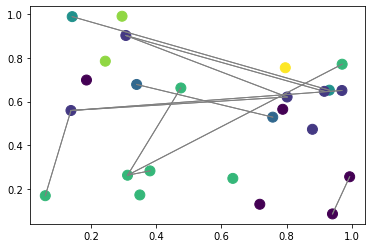

In [10]:
g.ndata.point = torch.rand(g.n_nodes, 2)
print(f"points:\n{g.ndata.point}")

support.plot_graph(adj[:25,:25], g.ndata.point[:25,:], g.ndata.label[:25])

### Setup model

In [11]:
model = gml.GCN(2, in_dim=n_feats, out_dim=n_classes)
model

GCN(
  (layers): ModuleList(
    (0): AdjConv(
      (linear): Linear(in_features=1433, out_features=16, bias=False)
      (act): ReLU()
    )
    (1): AdjConv(
      (linear): Linear(in_features=16, out_features=7, bias=False)
    )
  )
)

### Try a single feed forward

logits: torch.Size([2708, 7])
tensor([[-7663.5698, -3471.0513, -1673.0278,  ..., -4047.2346, -6235.3569,
          2459.1719],
        [ -121.2398,   -54.9501,   -26.6582,  ...,   -64.4378,   -98.8239,
            39.0276],
        [ -821.6373,  -368.4391,  -176.3697,  ...,  -433.5227,  -666.0255,
           262.9057],
        ...,
        [ -196.4792,   -88.5507,   -42.2918,  ...,  -103.3167,  -159.4355,
            62.8414],
        [ -188.1897,   -85.0049,   -41.1005,  ...,   -99.6200,  -153.4928,
            60.7719],
        [ -146.3981,   -66.2289,   -31.9379,  ...,   -77.4688,  -119.3720,
            47.2274]])
probabilities: torch.Size([2708, 7])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.8950e-26],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 

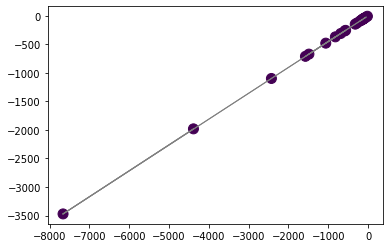

In [12]:
with torch.no_grad():
    logits = model(adj, g.ndata.feats)
print(f"logits: {logits.shape}")
print(logits)

softmax = nn.Softmax(dim=1)
probs = softmax(logits)
print(f"probabilities: {probs.shape}")
print(probs)

y_pred = probs.argmax(dim=1)
correct = (y_pred == g.ndata.label).type(torch.float).sum().item()
accuracy = (correct / g.n_nodes) * 100
print(f"y_predicted: {y_pred[:15]}")
print(f"true_labels: {g.ndata.label[:15]}")
print(f"accuracy: {accuracy:>0.1f}%")

support.plot_graph(adj[:25,:25], logits[:25,:], y_pred[:25])

### Training

In [13]:
learning_rate = 0.01
epochs = 200

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
for i in range(epochs):
    print(f"Epoch {i+1:<3} ------")
    loss = support.train(model, g, adj_norm, loss_fn, optimizer)
    print(f"loss: {loss:>7f}")
    accuracy = support.evaluate(model, g, adj_norm)
    print(f"accuracy: {accuracy:>0.1f}%")
    print()
print("done")

Epoch 1   ------
loss: 10.010898
accuracy: 30.2%

Epoch 2   ------
loss: 4.534521
accuracy: 15.4%

Epoch 3   ------
loss: 5.811084
accuracy: 15.4%

Epoch 4   ------
loss: 5.336728
accuracy: 30.2%

Epoch 5   ------
loss: 4.201620
accuracy: 13.0%

Epoch 6   ------
loss: 3.480466
accuracy: 13.0%

Epoch 7   ------
loss: 3.576235
accuracy: 6.8%

Epoch 8   ------
loss: 3.402553
accuracy: 15.1%

Epoch 9   ------
loss: 2.967563
accuracy: 13.5%

Epoch 10  ------
loss: 2.570776
accuracy: 6.8%

Epoch 11  ------
loss: 2.239549
accuracy: 15.8%

Epoch 12  ------
loss: 2.013803
accuracy: 30.7%

Epoch 13  ------
loss: 1.893080
accuracy: 30.6%

Epoch 14  ------
loss: 1.875035
accuracy: 38.7%

Epoch 15  ------
loss: 1.930472
accuracy: 12.8%

Epoch 16  ------
loss: 1.945601
accuracy: 12.1%

Epoch 17  ------
loss: 1.945756
accuracy: 11.7%

Epoch 18  ------
loss: 1.945813
accuracy: 11.6%

Epoch 19  ------
loss: 1.945839
accuracy: 11.6%

Epoch 20  ------
loss: 1.945855
accuracy: 11.2%

Epoch 21  ------
loss

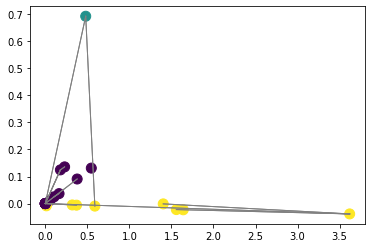

In [17]:
with torch.no_grad():
    logits = model(adj, g.ndata.feats)
y_pred = softmax(logits).argmax(dim=1)
support.plot_graph(adj[:25,:25], logits[:25,:], y_pred[:25])